<h1>Heisenberg antiferromagnet on the square lattice</h1>

<figure style="text-align:center">
    <img src="https://varipeps.readthedocs.io/en/latest/_images/square_lattice.svg"
         alt="Two dimensional square lattice with red links indicating horizontal and blue links indicating vertical interactions.">
    <figcaption><em>Two dimensional square lattice</em></figcaption>
</figure>

The Hamiltonian for the Heisenberg antiferromagnet with constant exchange interaction strength $J > 0$ is defined as:

$$ H = J \sum_{\langle ij \rangle} \vec{S}_{i} \vec{S}_{j} $$

where $\langle ij \rangle$ denotes the sum over all nearest neighbors in the lattice.

Our aim is now to find the ground state of the model using the variational iPEPS code of the variPEPS library.

<h2>Loading of relevant Python modules</h2>

In [12]:
import matplotlib
from matplotlib import pyplot as plt
import varipeps
import jax
import jax.numpy as jnp

First of all we have to load the relevant Python modules for our simulation. The [`varipeps`](https://varipeps.readthedocs.io/en/latest/api/index.html) module includes the full library to perform the variational optimization. Internally it is based on the [`jax`](https://docs.jax.dev/en/latest/) framework and its [`numpy`](https://numpy.org/doc/stable/reference/index.html)-like interface to execute the calculations. Since we will need arrays to define for example the Hamiltonian, we load this numpy interface as well.

<h2>variPEPS config settings</h2>

In [3]:
# Config Setting

## Set maximal steps for the CTMRG routine
varipeps.config.ctmrg_max_steps = 100
## Set convergence threshold for the CTMRG routine
varipeps.config.ctmrg_convergence_eps = 1e-7
## Select the method used to calculate the (full) projectors in the CTMRG routine
varipeps.config.ctmrg_full_projector_method = (
    varipeps.config.Projector_Method.FISHMAN
)
## Enable dynamic increase of CTMRG environment bond dimension
varipeps.config.ctmrg_heuristic_increase_chi = True
## Increase CTMRG enviroment bond dimension if truncation error exceeds this value
varipeps.config.ctmrg_heuristic_increase_chi_threshold = 1e-4

## Set maximal steps for the fix point routine in the gradient calculation
varipeps.config.ad_custom_max_steps = 100
## Set convergence threshold for the fix point routine in the gradient calculation
varipeps.config.ad_custom_convergence_eps = 5e-8

## Enable/Disable printing of the convergence of the single CTMRG/gradient fix point steps.
## Useful to enable this during debugging, should be disabled for batch runs
varipeps.config.ctmrg_print_steps = True
varipeps.config.ad_custom_print_steps = False

## Select the method used to calculate the descent direction during optimization
varipeps.config.optimizer_method = varipeps.config.Optimizing_Methods.L_BFGS
## Set maximal number of steps for the optimization routine
varipeps.config.optimizer_max_steps = 2000

The [`varipeps`](https://varipeps.readthedocs.io/en/latest/api/index.html) library allows to configure a large number of numerical parameters to fine-tune the simulation. In this example we include several options commonly used in an optimization run. For a detailed description of the configurable options we refer to the API description of the config class: [`varipeps.config.VariPEPS_Config`](https://varipeps.readthedocs.io/en/latest/api/config.html#varipeps.config.VariPEPS_Config).

<h2>Model parameters</h2>

In [4]:
# Set constants for the simulation
modelName = "HeisenbergModel"
# Interaction strength
J = 1
# iPEPS bond dimension
chiB = 2
# Physical dimension
p = 2
# Maximal enviroment bond dimension
maxChi = 36
# Start value for enviroment bond dimension
startChi = chiB**2 if chiB**2 < maxChi else maxChi

In this block we define imporant parameters for the model we want to simulate, such as as the interaction strength, the physical dimension of our tensor network and the iPEPS bond dimension. In the last two lines the initial and the maximal enviroment bond dimension is defined. A feature of the variPEPS library is that it not only supports simulation at a fixed enviroment bond dimension, but also a heurisitic increase/decrease of the dimension up to a maximal value. The dynamic change is controlled by the truncation error in the CTMRG projector calculation (increase if the truncation errror becomes too large, decrease if it becomes insignificant). For example, in the config block above the parameter ``ctmrg_heuristic_increase_chi_threshold`` is set to the threshold at which to increase the refinement parameter. The maximal bond dimension ``maxChi`` ensures that the parameter does now grow unbounded, to the point where the memory and computational resources are exhausted.

<h2>Constructing the Hamiltonian</h2>

In [5]:
# define spin-1/2 matrices
Id = jnp.eye(2)
Sx = jnp.array([[0, 1], [1, 0]]) / 2
Sy = jnp.array([[0, -1j], [1j, 0]]) / 2
Sz = jnp.array([[1, 0], [0, -1]]) / 2

# construct Hamiltonian terms
hamiltonianGates = J * (jnp.kron(Sx, Sx) + jnp.kron(Sy, Sy) + jnp.kron(Sz, Sz))

# create function to compute expectation values for the square Heisenberg AFM
exp_func = varipeps.expectation.Two_Sites_Expectation_Value(
    horizontal_gates=(hamiltonianGates,),
    vertical_gates=(hamiltonianGates,),
)

Here the Hamiltonian is constructed for our model. The Heisenberg AFM on the square lattice can be described by the sum of the spin-spin interactions on the horizontal and vertical bonds. Since we assume a constant interaction strength for all bonds in our example, the expectation value can be calculated by the same two-site interaction gate applied in all nearest neighbor directions. The expectation function ``exp_func`` is later used in the optimization to calculate the energy expectation value, which in turn is used as cost function to obtain the ground state.

<h2>Initial unit cell construction</h2>

In [6]:
# Unit cell structure
structure = [[0, 1], [1, 0]]

Here we define the unit cell structure which is used to simulate our model. In this example we assume a $\scriptsize{\begin{matrix}A&B\\B&A\end{matrix}}$-structure, i.e. a two-site antiferromagnetic state.

In [7]:
# Create random initialization for the iPEPS unit cell
unitcell = varipeps.peps.PEPS_Unit_Cell.random(
    structure,  # Unit cell structure
    p,  # Physical dimension
    chiB,  # iPEPS bond dimension
    startChi,  # Start value for enviroment bond dimension
    float,  # Data type for the tensors: `float` (real) or `complex` tensors
    max_chi=maxChi,  # Maximal enviroment bond dimension
)

Using the unit cell structure and the model parameter defined above, we can generate an initial unit cell. Here we initialize the iPEPS tensors with random numbers. Other ways to initialize the tensors are provided, for example loading results from a simple update calculation.

<h2>Run the optimization</h2>

In [8]:
# Run optimization
result = varipeps.optimization.optimize_peps_network(
    unitcell,
    exp_func,
    autosave_filename=f"data/autosave_square_chiB_{chiB:d}.hdf5",
)

Optimizing PEPS state: 0it [00:00, ?it/s]

CTMRG: 0: 2.5208010459606154
CTMRG: 1: 3.2121904324699515
CTMRG: 2: 1.4434088693133413
CTMRG: 3: 0.42806931432789425
CTMRG: 4: 0.5017490544074585
CTMRG: 5: 0.1225627579818547
CTMRG: 6: 0.04064118511908092
CTMRG: 7: 0.016257650737477966
CTMRG: 8: 0.005880288329888076
CTMRG: 9: 0.0024259187028422735
CTMRG: 10: 0.0010828896005150778
CTMRG: 11: 0.0004918379586950627
CTMRG: 12: 0.0002221263334433953
CTMRG: 13: 9.961510053002307e-05
CTMRG: 14: 4.431510364505571e-05
CTMRG: 15: 1.9789873702427036e-05
CTMRG: 16: 8.917598656927234e-06
CTMRG: 17: 4.025398957508013e-06
CTMRG: 18: 1.812929137917207e-06
CTMRG: 19: 8.161649735498116e-07
CTMRG: 20: 3.6774111463630603e-07
CTMRG: 21: 1.657341581264588e-07
CTMRG: Increasing chi to 6 since smallest SVD Norm was 0.023734189308657547.
CTMRG: 0: 0.34032308309282044
CTMRG: 1: 0.8474980679925416
CTMRG: 2: 1.0880070387092646
CTMRG: 3: 0.029383252752937933
CTMRG: 4: 0.7086685486776667
CTMRG: 5: 0.005311406731947948
CTMRG: 6: 0.0019224383857430489
CTMRG: 7: 0.001

/tmp/venv_varipeps/lib/python3.13/site-packages/jax/_src/lax/lax.py:5464: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


CTMRG: 0: 2.5640633261288923
CTMRG: 1: 2.951073201306888
CTMRG: 2: 3.5268842183267175
CTMRG: 3: 3.4580081240028964
CTMRG: 4: 3.1619922178797175
CTMRG: 5: 2.6962740706129815
CTMRG: 6: 2.052259734237112
CTMRG: 7: 0.8928831088420028
CTMRG: 8: 0.5475661586919297
CTMRG: 9: 1.174396054461796
CTMRG: 10: 0.06423645559389293
CTMRG: 11: 0.013933645458869376
CTMRG: 12: 0.007431785120266764
CTMRG: 13: 0.0026791905941730113
CTMRG: 14: 0.001045538345612264
CTMRG: 15: 0.00040987616919765615
CTMRG: 16: 0.00014263185482005827
CTMRG: 17: 6.59879517479851e-05
CTMRG: 18: 2.2230504657500514e-05
CTMRG: 19: 9.246380189725043e-06
CTMRG: 20: 3.5869241002195963e-06
CTMRG: 21: 1.386982746806637e-06
CTMRG: 22: 5.451386966238428e-07
CTMRG: 23: 2.0748458553983812e-07
CTMRG: Increasing chi to 26 since smallest SVD Norm was 0.0001546976007613086.
CTMRG: 0: 0.08024753803644623
CTMRG: 1: 0.6582670959054592
CTMRG: 2: 0.005581674625418066
CTMRG: 3: 0.0006170592202477625
CTMRG: 4: 7.588843816220124e-05
CTMRG: 5: 3.4247669

/tmp/venv_varipeps/lib/python3.13/site-packages/jax/_src/lax/lax.py:5464: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


Line search: Recalculate original unitcell with higher chi 28.
CTMRG: 0: 0.40283894323409075
CTMRG: 1: 0.6175706823874736
CTMRG: 2: 0.015340644483339898
CTMRG: 3: 0.0009422665465535358
CTMRG: 4: 0.00012510184557176681
CTMRG: 5: 1.6922616876389503e-05
CTMRG: 6: 3.2454477128848616e-06
CTMRG: 7: 6.62270251413152e-07
CTMRG: 8: 1.549982148398939e-07
CTMRG: 0: 3.9845441925831e-08
CTMRG: 0: 2.6205614312922596
CTMRG: 1: 3.3531622319193333
CTMRG: 2: 3.5508106221523548
CTMRG: 3: 3.7789488127797917
CTMRG: 4: 3.039629358878179
CTMRG: 5: 2.8318404640821457
CTMRG: 6: 2.166265040273595
CTMRG: 7: 1.6224890396325158
CTMRG: 8: 1.0062049574661491
CTMRG: 9: 0.549527103339964
CTMRG: 10: 0.5485146052992033
CTMRG: 11: 0.00452557320826167
CTMRG: 12: 0.0023799098417814327
CTMRG: 13: 0.0010507339418414008
CTMRG: 14: 0.0005528308691249724
CTMRG: 15: 0.00020980185918371885
CTMRG: 16: 8.729136788347134e-05
CTMRG: 17: 3.223686181879019e-05
CTMRG: 18: 1.534053173492083e-05
CTMRG: 19: 6.2518980741051335e-06
CTMRG: 20

/tmp/venv_varipeps/lib/python3.13/site-packages/jax/_src/lax/lax.py:5464: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


CTMRG: 0: 1.5551261359220875e-07


/tmp/venv_varipeps/lib/python3.13/site-packages/jax/_src/lax/lax.py:5464: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


CTMRG: 0: 2.6020196979271124
CTMRG: 1: 2.5288062340464488
CTMRG: 2: 2.369366325773301
CTMRG: 3: 2.3248994464068704
CTMRG: 4: 1.0307401747379419
CTMRG: 5: 0.5457420995493841
CTMRG: 6: 0.10634670169835371
CTMRG: 7: 0.0013095657122789177
CTMRG: 8: 0.0002069659013125571
CTMRG: 9: 3.339482524912161e-05
CTMRG: 10: 5.821071829901025e-06
CTMRG: 11: 9.57498225844154e-07
CTMRG: 12: 2.2462981262251786e-07
CTMRG: 0: 2.554136087661491
CTMRG: 1: 2.1110482939609243
CTMRG: 2: 1.8358194458562356
CTMRG: 3: 1.630249178194098
CTMRG: 4: 1.012539636362767
CTMRG: 5: 0.7649784387832259
CTMRG: 6: 0.3018169822513155
CTMRG: 7: 0.009875735666965792
CTMRG: 8: 0.002589738242928751
CTMRG: 9: 0.0005790300476547102
CTMRG: 10: 0.00013973312737293984
CTMRG: 11: 3.2068568729700275e-05
CTMRG: 12: 7.679838006396926e-06
CTMRG: 13: 2.0754547665981407e-06
CTMRG: 14: 7.237897631209731e-07
CTMRG: 15: 6.452927065425335e-07
CTMRG: 16: 8.24953305987198e-07
CTMRG: 17: 1.3562780746888018e-06
CTMRG: 18: 1.195544330292598e-06
CTMRG: 1

/tmp/venv_varipeps/lib/python3.13/site-packages/jax/_src/lax/lax.py:5464: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


CTMRG: 0: 4.4433521908056124e-07
CTMRG: 1: 5.465523157520803e-07
CTMRG: 2: 3.038699780919873e-07


/tmp/venv_varipeps/lib/python3.13/site-packages/jax/_src/lax/lax.py:5464: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


CTMRG: 0: 2.5406101162164525
CTMRG: 1: 1.826878196600978
CTMRG: 2: 1.614504432099387
CTMRG: 3: 1.4249566847484032
CTMRG: 4: 1.1001205075277896
CTMRG: 5: 0.5285626474617147
CTMRG: 6: 0.002644435519167429
CTMRG: 7: 0.00047009505215151175
CTMRG: 8: 0.00010953267955341004
CTMRG: 9: 2.4687978561667427e-05
CTMRG: 10: 6.005194867799592e-06
CTMRG: 11: 1.6007551646990751e-06
CTMRG: 12: 7.86369809992529e-07
CTMRG: 13: 4.571105407136827e-07
CTMRG: 14: 5.564872821324752e-07
CTMRG: 15: 7.234520229826247e-07
CTMRG: 16: 1.261914633030194e-06
CTMRG: 17: 4.66865442631788e-07
CTMRG: 18: 1.107542458420739e-06
CTMRG: 19: 8.656520733628008e-07
CTMRG: 20: 4.564749393489681e-07
CTMRG: 21: 7.229550668867278e-07
CTMRG: 22: 1.3178322302964132e-06
CTMRG: 23: 1.3712084490290197e-06
CTMRG: 24: 1.4448559665615708e-06
CTMRG: 25: 1.2906286892086178e-06
CTMRG: 26: 4.250237097070586e-07
CTMRG: 27: 6.358641471870578e-07
CTMRG: 28: 8.370654612104099e-07
CTMRG: 29: 1.466200516090169e-06
CTMRG: 30: 1.298849936222198e-06
CT

/tmp/venv_varipeps/lib/python3.13/site-packages/jax/_src/lax/lax.py:5464: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


CTMRG: 0: 1.4684367454531203e-06
CTMRG: 1: 1.4862505630444211e-06
CTMRG: 2: 1.6073458254297368e-06
CTMRG: 3: 1.5497191471553815e-06
CTMRG: 4: 9.343125929901728e-07
CTMRG: 5: 8.608426627092745e-07
CTMRG: 6: 9.650786284209145e-07
CTMRG: 7: 1.6259772406281933e-06
CTMRG: 8: 1.633325741952992e-06
CTMRG: 9: 1.3485501225419099e-06
CTMRG: 10: 1.8791296764406441e-06
CTMRG: 11: 1.1504600734170432e-06
CTMRG: 12: 8.691877667350473e-07
CTMRG: 13: 1.1028652709648375e-06
CTMRG: 14: 9.395092181939829e-07
CTMRG: 15: 1.1723947009331796e-06
CTMRG: 16: 1.053996662447014e-06
CTMRG: 17: 1.730943215703938e-06
CTMRG: 18: 1.566552506765563e-06
CTMRG: 19: 7.06702944101447e-07
CTMRG: 20: 5.693766268002319e-07
CTMRG: 21: 1.8768705112896588e-06
CTMRG: 22: 1.9399464518478722e-06
CTMRG: 23: 1.7264591165573422e-06
CTMRG: 24: 1.3109800452210912e-06
CTMRG: 25: 6.569613720597035e-07
CTMRG: 26: 9.94163154404595e-07
CTMRG: 27: 9.205169793031163e-07
CTMRG: 28: 1.4811024200136893e-06
CTMRG: 29: 2.4395456198096624e-06
CTMRG:

/tmp/venv_varipeps/lib/python3.13/site-packages/jax/_src/lax/lax.py:5464: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


CTMRG: 0: 2.58638115961598
CTMRG: 1: 2.09332300802995
CTMRG: 2: 1.7704458721352314
CTMRG: 3: 1.0057415786266453
CTMRG: 4: 0.6977789887095042
CTMRG: 5: 0.4089814033944242
CTMRG: 6: 0.20778983455722955
CTMRG: 7: 0.008639783643985707
CTMRG: 8: 0.000634957440072314
CTMRG: 9: 6.065963326374462e-05
CTMRG: 10: 2.2470027744355102e-05
CTMRG: 11: 1.1652961366022501e-05
CTMRG: 12: 2.847221007039665e-06
CTMRG: 13: 3.1817304489889947e-06
CTMRG: 14: 8.768023252191148e-07
CTMRG: 15: 3.8839956044995116e-06
CTMRG: 16: 3.704303675021957e-06
CTMRG: 17: 1.1111982945621133e-06
CTMRG: 18: 3.3044118568804055e-06
CTMRG: 19: 2.811031877392375e-06
CTMRG: 20: 7.653866517215424e-06
CTMRG: 21: 2.2173304185904234e-06
CTMRG: 22: 1.8737803012278505e-05
CTMRG: 23: 1.5005030727692681e-05
CTMRG: 24: 5.737127672402899e-06
CTMRG: 25: 1.0985748670362877e-06
CTMRG: 26: 2.879371565253361e-06
CTMRG: 27: 4.34034366028638e-06
CTMRG: 28: 6.944359033952341e-06
CTMRG: 29: 5.529719756680396e-06
CTMRG: 30: 1.981892518751021e-06
CTMR

/tmp/venv_varipeps/lib/python3.13/site-packages/jax/_src/lax/lax.py:5464: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


CTMRG: 0: 1.2731826466595473e-07
CTMRG: Decreasing chi to 20 since smallest SVD Norm was 0.0 or routine did not converge.
CTMRG: 0: 2.477978029314664
CTMRG: 1: 1.4800643988510411
CTMRG: 2: 1.8907899346593808
CTMRG: 3: 1.2391799958324763
CTMRG: 4: 0.6758772153080097
CTMRG: 5: 0.49770759763901923
CTMRG: 6: 0.03384344603071866
CTMRG: 7: 0.39746853679038424
CTMRG: 8: 0.004036835369914388
CTMRG: 9: 0.00034382581720894913
CTMRG: 10: 2.673022864693479e-05
CTMRG: 11: 3.3772429432419885e-06
CTMRG: 12: 7.463598565253951e-07
CTMRG: 13: 2.079982663517517e-07
CTMRG: Decreasing chi to 19 since smallest SVD Norm was 0.0 or routine did not converge.
CTMRG: 0: 2.477978029314664
CTMRG: 1: 1.4800643988510411
CTMRG: 2: 1.890891458179388
CTMRG: 3: 1.2359939199343994
CTMRG: 4: 0.6630075869030764
CTMRG: 5: 0.36459768620571087
CTMRG: 6: 0.006848255061076349
CTMRG: 7: 0.0009180223397610442
CTMRG: 8: 0.0001329455528101105
CTMRG: 9: 2.746682467848947e-05
CTMRG: 10: 7.238709137054235e-06
CTMRG: 11: 2.030863151807

/tmp/venv_varipeps/lib/python3.13/site-packages/jax/_src/lax/lax.py:5464: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


CTMRG: 0: 2.4766778362752233
CTMRG: 1: 1.4580216003881044
CTMRG: 2: 1.8973700188225402
CTMRG: 3: 0.7355467229730861
CTMRG: 4: 0.6303205203597785
CTMRG: 5: 0.03866230997245523
CTMRG: 6: 0.006288373540846897
CTMRG: 7: 0.0009039742836384643
CTMRG: 8: 0.00015411108134301372
CTMRG: 9: 3.6486423191359766e-05
CTMRG: 10: 1.0053642825844499e-05
CTMRG: 11: 2.865586073947703e-06
CTMRG: 12: 8.223516865805401e-07
CTMRG: 13: 2.3680598988674783e-07
CTMRG: 14: 7.217051126579791e-08
CTMRG: 0: 2.471792174325316
CTMRG: 1: 1.6838284020234717
CTMRG: 2: 1.779528443737789
CTMRG: 3: 1.1264217573687634
CTMRG: 4: 0.35248436899284846
CTMRG: 5: 0.03285868816266157
CTMRG: 6: 0.005741585556816909
CTMRG: 7: 0.0008356575739825289
CTMRG: 8: 0.00014042852744670548
CTMRG: 9: 3.379589952226907e-05
CTMRG: 10: 9.827932342205763e-06
CTMRG: 11: 2.971805445143063e-06
CTMRG: 12: 9.041751673885342e-07
CTMRG: 13: 2.7539893411828147e-07
CTMRG: 14: 8.391567369704503e-08


/tmp/venv_varipeps/lib/python3.13/site-packages/jax/_src/lax/lax.py:5464: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


CTMRG: 0: 2.559869398453305e-08
CTMRG: 0: 2.47183005729656
CTMRG: 1: 1.876566914049325
CTMRG: 2: 1.4163653592696241
CTMRG: 3: 1.1195774126230986
CTMRG: 4: 0.46158151997617414
CTMRG: 5: 0.03278681790280401
CTMRG: 6: 0.0057384490389260565
CTMRG: 7: 0.0008296916735971583
CTMRG: 8: 0.00013748199103033712
CTMRG: 9: 3.282388831632027e-05
CTMRG: 10: 9.546353294739719e-06
CTMRG: 11: 2.8909815676395426e-06
CTMRG: 12: 8.812769276704286e-07
CTMRG: 13: 2.6980751881079995e-07
CTMRG: 14: 8.220443344199873e-08
CTMRG: 0: 2.472591358148995
CTMRG: 1: 1.870897480480235
CTMRG: 2: 1.4607769590568174
CTMRG: 3: 0.6737163755202116
CTMRG: 4: 0.41951491078168546
CTMRG: 5: 0.33600721411995665
CTMRG: 6: 0.005446958642526244
CTMRG: 7: 0.31819984181768163
CTMRG: 8: 0.00012071098555564667
CTMRG: 9: 2.783106255449689e-05
CTMRG: 10: 8.15375525318676e-06
CTMRG: 11: 2.4998561979390053e-06
CTMRG: 12: 7.70022133883232e-07
CTMRG: 13: 2.3725857380223193e-07
CTMRG: 0: 7.335285239430263e-08
CTMRG: 0: 2.472677392726361
CTMRG: 

This function call executes the main function of the library, the variational energy optimization to obtain a good ground state candidate. The function offers several options to customize the optimization for different iPEPS ansätze, such as the spiral iPEPS approach. In our example, we only need to provide the initial unit cell, the function for calculating the energy expectation value, and a file path for autosaving the optimization process, enabling the restoration of interrupted simulations.

<h2>Evaluate the results</h2>

In this section we show some exemplary evaluation of the result of the optimization.

In [9]:
# Calculate magnetic expectation values
Mag_Gates = [Sx, Sy, Sz]


def calc_magnetic(unitcell):
    mag_result = []
    for ti, t in enumerate(unitcell.get_unique_tensors()):
        r = varipeps.expectation.one_site.calc_one_site_multi_gates(
            t.tensor, t, Mag_Gates
        )
        mag_result += r
    return mag_result


magnetic_exp_values = calc_magnetic(result.unitcell)

We assume for our example that we are interested in the single-site spin expectation values. These could be used to analyse the $z$-magnetization or the staggered magnetization of our model at/near the ground state.

In [10]:
# Define some auxiliary data which should be stored along the final iPEPS unit cell
auxiliary_data = {
    "best_energy": result.fun,
    "best_run": result.best_run,
    "magnetic_exp_values": magnetic_exp_values,
}
for k in sorted(result.max_trunc_error_list.keys()):
    auxiliary_data[f"max_trunc_error_list_{k:d}"] = result.max_trunc_error_list[k]
    auxiliary_data[f"step_energies_{k:d}"] = result.step_energies[k]
    auxiliary_data[f"step_chi_{k:d}"] = result.step_chi[k]
    auxiliary_data[f"step_conv_{k:d}"] = result.step_conv[k]
    auxiliary_data[f"step_runtime_{k:d}"] = result.step_runtime[k]

# save full iPEPS state
result.unitcell.save_to_file(
    f"data/heisenberg_square_J_{J:d}_chiB_{chiB:d}_chiMax_{maxChi:d}.hdf5",
    auxiliary_data=auxiliary_data,
)

Finally, we want to save the unit cell with the optimized tensors to a file for further analysis. The library allows to store the data directly into a HDF5 file along with user-supplied auxiliary data. Here, for example, we not only want to store the plain tensors but also the calculated energy, meta information from the optimization run (e.g. energy per step or the runtime per step) and the calculated magnetic expectation values. At a later examination of the results, these data can be easily loaded along with the tensors of the tensor network.

In [11]:
magnetic_exp_values

[Array(-0.27174081, dtype=float64),
 Array(0., dtype=float64),
 Array(0.26717753, dtype=float64),
 Array(0.27173978, dtype=float64),
 Array(0., dtype=float64),
 Array(-0.26717826, dtype=float64)]

In [13]:
jnp.linalg.norm(jnp.asarray(magnetic_exp_values[:3])), jnp.linalg.norm(jnp.asarray(magnetic_exp_values[3:]))

(Array(0.38108647, dtype=float64), Array(0.38108625, dtype=float64))

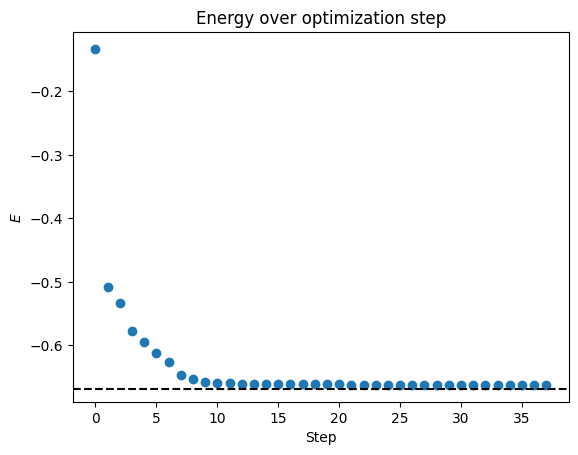

In [38]:
plt.scatter(jnp.arange(len(result.step_energies[0])), result.step_energies[0])
plt.axhline(y=-0.669, color="k", linestyle="--")
plt.xlabel("Step")
plt.ylabel("$E$")
plt.title("Energy over optimization step")
plt.show()

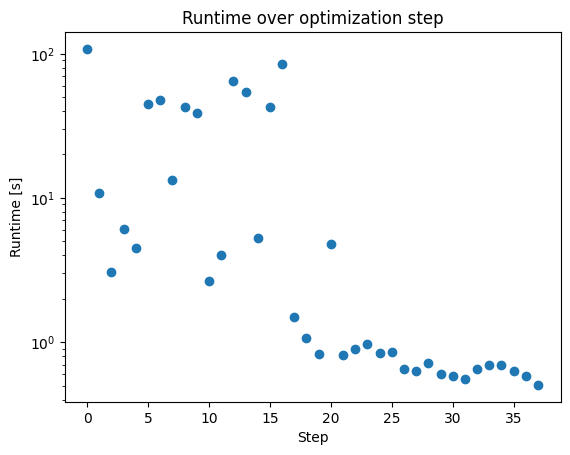

In [27]:
plt.scatter(jnp.arange(len(result.step_runtime[0])), result.step_runtime[0])
plt.yscale("log")
plt.xlabel("Step")
plt.ylabel("Runtime [s]")
plt.title("Runtime over optimization step")
plt.show()

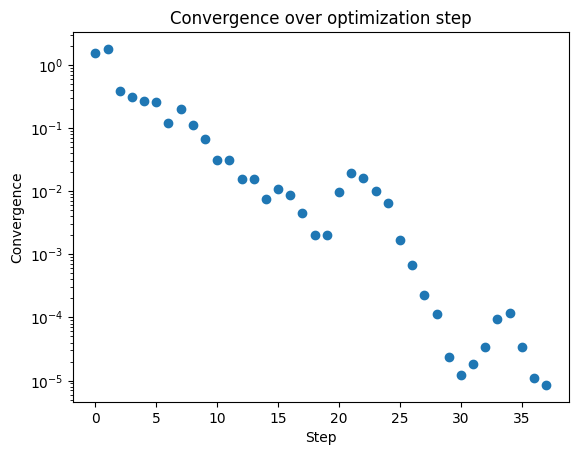

In [28]:
plt.scatter(jnp.arange(len(result.step_conv[0])), result.step_conv[0])
plt.yscale("log")
plt.xlabel("Step")
plt.ylabel("Convergence")
plt.title("Convergence over optimization step")
plt.show()

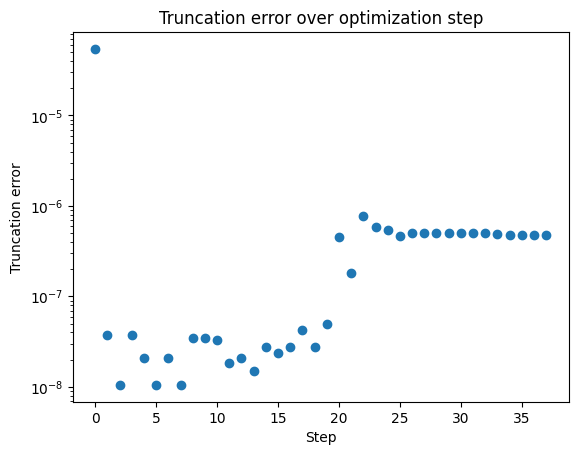

In [25]:
plt.scatter(jnp.arange(len(result.max_trunc_error_list[0])), result.max_trunc_error_list[0])
plt.yscale("log")
plt.xlabel("Step")
plt.ylabel("Truncation error")
plt.title("Truncation error over optimization step")
plt.show()